# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'
p_type = 'FMB'
cluster = 1

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 35)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  
dataset = dataset[dataset['Cluster']==cluster].reset_index(drop=True).copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (75685, 36)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    75418
Ct 90_결과      39954
M/B_결과            0
M/B_기준            0
Scorch_결과     13169
Vm_결과         29498
경도_결과         56760
dtype: int64


## ***MODELLING***
---

In [10]:
### Train Test Split 
# Targets 
targets = ['Ct 90_결과','Scorch_결과','Vm_결과','경도_결과']

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type)

# Scorch
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type)

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(dataset, targets[2], p_type)

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(dataset, targets[3], p_type)

# Print 
print('='*100)
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

Ct 90_결과             |          6,110 |         1,434
Scorch_결과            |          8,537 |         2,003
Vm_결과                |         18,863 |         4,425
경도_결과               |         13,855 |         3,251


[I 2025-10-31 08:54:23,425] A new study created in memory with name: no-name-dc9cf6ec-271a-488f-ad41-04fa951d9a53


학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 6110


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 08:54:25,061] Trial 0 finished with value: 7.200391414357147 and parameters: {'n_estimators': 2800, 'max_depth': 8, 'learning_rate': 0.12444179160162018, 'subsample': 0.8649493094004188, 'gamma': 0.022457694173396936, 'reg_lambda': 0.0027462362840261216}. Best is trial 0 with value: 7.200391414357147.
[I 2025-10-31 08:54:26,037] Trial 1 finished with value: 7.16672578828042 and parameters: {'n_estimators': 330, 'max_depth': 12, 'learning_rate': 0.09052865284273252, 'subsample': 0.9130749985130981, 'gamma': 0.4043509376656826, 'reg_lambda': 2.218993309193103}. Best is trial 1 with value: 7.16672578828042.
[I 2025-10-31 08:54:28,244] Trial 2 finished with value: 7.635793983968099 and parameters: {'n_estimators': 1413, 'max_depth': 7, 'learning_rate': 0.00361051039711465, 'subsample': 0.8932427753066111, 'gamma': 0.35795419600097556, 'reg_lambda': 0.0014674187488940443}. Best is trial 1 with value: 7.16672578828042.
[I 2025-10-31 08:54:29,790] Trial 3 finished with value: 7.

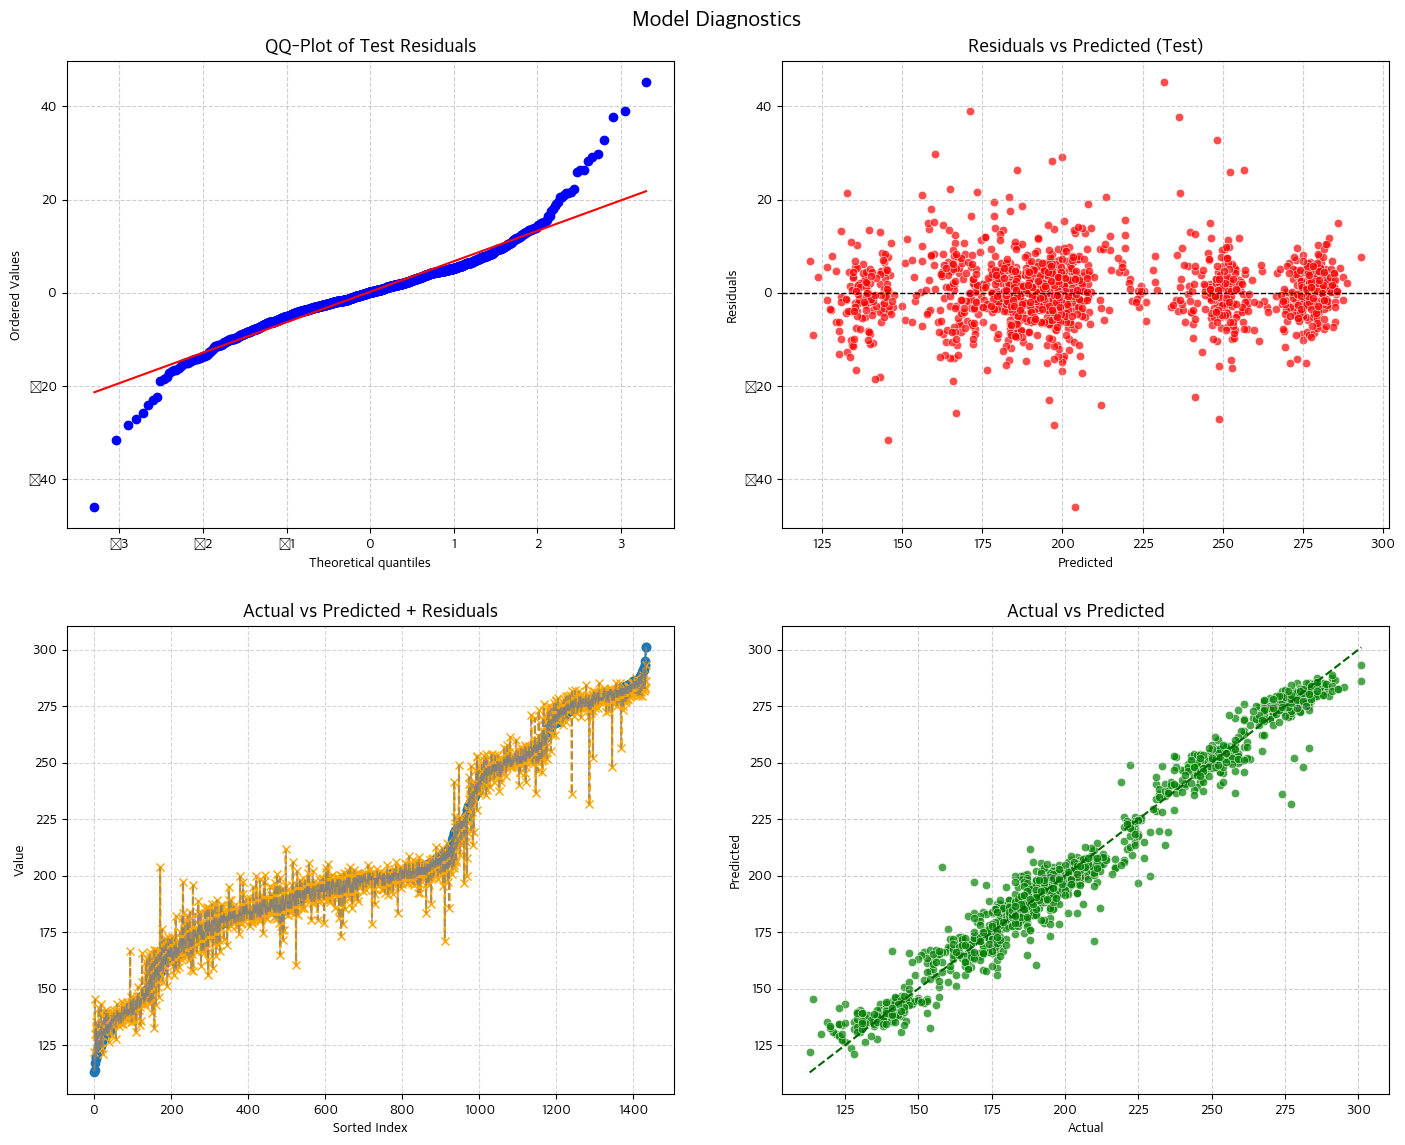

[I 2025-10-31 08:54:52,567] A new study created in memory with name: no-name-d78f04ab-f9cd-4dcb-a921-8b8132abd43c


Train Accuracy
Train RMSE : 2.300
Train R2   : 0.997
Train SMAPE : 0.83
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 6.769
Test R2   : 0.977
Test SMAPE : 2.42
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 8537


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 08:54:59,728] Trial 0 finished with value: 23.12116305423394 and parameters: {'n_estimators': 1507, 'max_depth': 7, 'learning_rate': 0.034172218200754056, 'subsample': 0.788392556878034, 'gamma': 0.11247374358272666, 'reg_lambda': 0.6234165006267173}. Best is trial 0 with value: 23.12116305423394.
[I 2025-10-31 08:55:05,423] Trial 1 finished with value: 23.56672917652056 and parameters: {'n_estimators': 2808, 'max_depth': 8, 'learning_rate': 0.061490267924855, 'subsample': 0.8868619975224412, 'gamma': 0.2628636098650532, 'reg_lambda': 0.0052956622558016295}. Best is trial 0 with value: 23.12116305423394.
[I 2025-10-31 08:55:11,668] Trial 2 finished with value: 22.9604155712184 and parameters: {'n_estimators': 1301, 'max_depth': 10, 'learning_rate': 0.006925825595267713, 'subsample': 0.7256854577300911, 'gamma': 0.11495740211322875, 'reg_lambda': 0.2727320689987898}. Best is trial 2 with value: 22.9604155712184.
[I 2025-10-31 08:55:14,995] Trial 3 finished with value: 23.5

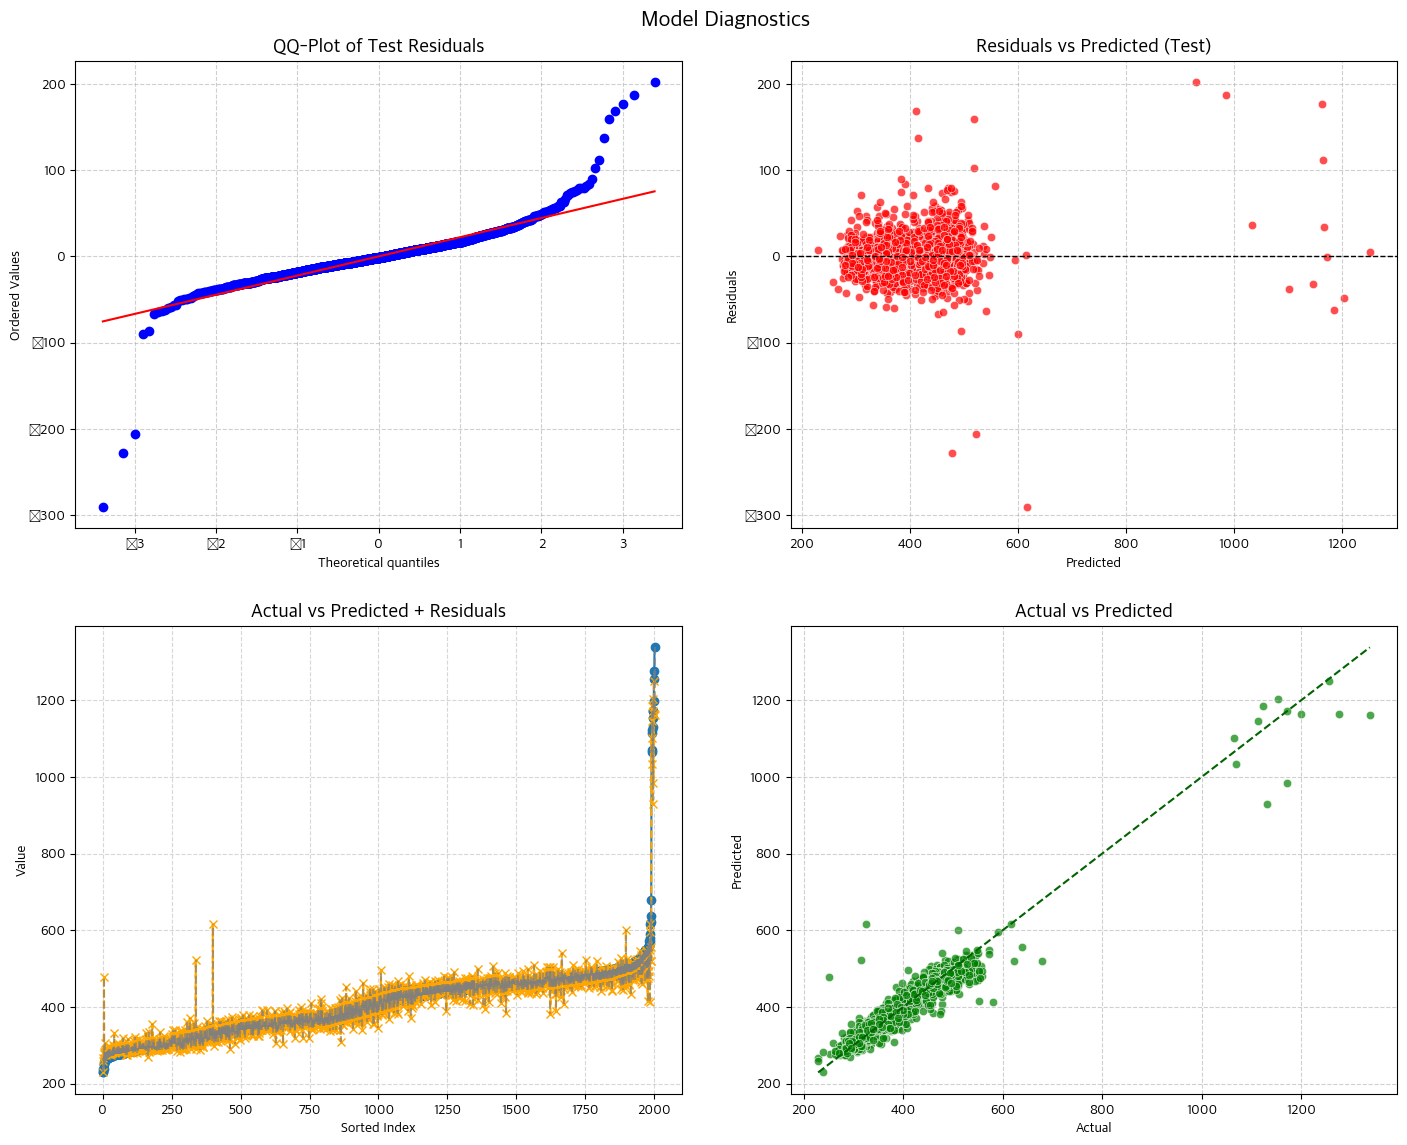

[I 2025-10-31 08:55:33,724] A new study created in memory with name: no-name-8c703a1e-7d94-4674-aaf4-0d935fb0de9f


Train Accuracy
Train RMSE : 9.258
Train R2   : 0.989
Train SMAPE : 1.78
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 24.289
Test R2   : 0.934
Test SMAPE : 3.92
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 18863


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 08:55:37,315] Trial 0 finished with value: 1.5043947401626556 and parameters: {'n_estimators': 2499, 'max_depth': 7, 'learning_rate': 0.008855150376549801, 'subsample': 0.8406543106214145, 'gamma': 0.48374100717519974, 'reg_lambda': 2.130949116094405}. Best is trial 0 with value: 1.5043947401626556.
[I 2025-10-31 08:55:38,132] Trial 1 finished with value: 1.706965245740008 and parameters: {'n_estimators': 627, 'max_depth': 6, 'learning_rate': 0.022064869562760527, 'subsample': 0.9860483627042058, 'gamma': 0.4548890183761423, 'reg_lambda': 1.0816547703427473}. Best is trial 0 with value: 1.5043947401626556.
[I 2025-10-31 08:55:38,821] Trial 2 finished with value: 1.5309085315501316 and parameters: {'n_estimators': 945, 'max_depth': 12, 'learning_rate': 0.24181822311506096, 'subsample': 0.7830828047133854, 'gamma': 0.4484399764944403, 'reg_lambda': 0.0010689481164570982}. Best is trial 0 with value: 1.5043947401626556.
[I 2025-10-31 08:55:41,598] Trial 3 finished with value

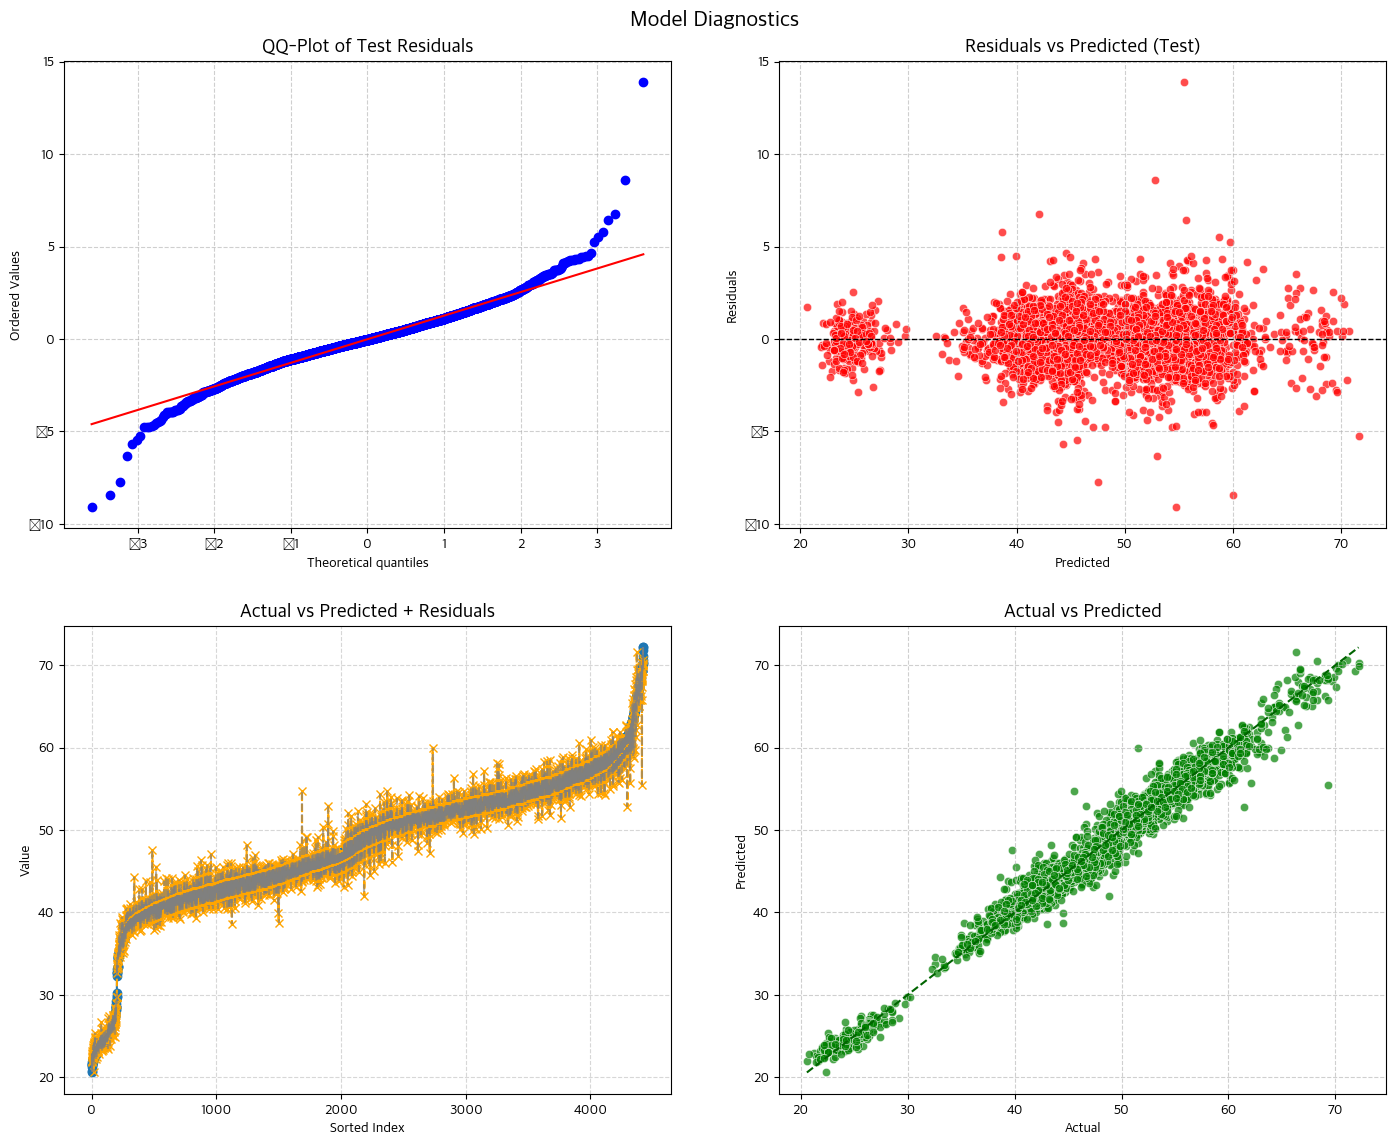

[I 2025-10-31 08:56:13,620] A new study created in memory with name: no-name-2bcd3d9a-d211-4c5f-9813-89aae7a68c84


Train Accuracy
Train RMSE : 0.216
Train R2   : 0.999
Train SMAPE : 0.33
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.299
Test R2   : 0.976
Test SMAPE : 2.02
학습할 Tree Features: 17 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'Vm_feature']
학습 Tree 데이터 수: 13855


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 08:56:16,843] Trial 0 finished with value: 1.1708485784881033 and parameters: {'n_estimators': 2721, 'max_depth': 7, 'learning_rate': 0.0027074934233266433, 'subsample': 0.8013621752592812, 'gamma': 0.2696336389859509, 'reg_lambda': 0.31921164897104204}. Best is trial 0 with value: 1.1708485784881033.
[I 2025-10-31 08:56:21,443] Trial 1 finished with value: 1.1367031893378412 and parameters: {'n_estimators': 1387, 'max_depth': 10, 'learning_rate': 0.004554620864285971, 'subsample': 0.9810644724126052, 'gamma': 0.09325787048889256, 'reg_lambda': 0.10490638938317198}. Best is trial 1 with value: 1.1367031893378412.
[I 2025-10-31 08:56:24,090] Trial 2 finished with value: 1.1608720091260796 and parameters: {'n_estimators': 1720, 'max_depth': 6, 'learning_rate': 0.08684740249770316, 'subsample': 0.7220385802572731, 'gamma': 0.0021844787753173556, 'reg_lambda': 0.004540107751792599}. Best is trial 1 with value: 1.1367031893378412.
[I 2025-10-31 08:56:28,914] Trial 3 finished w

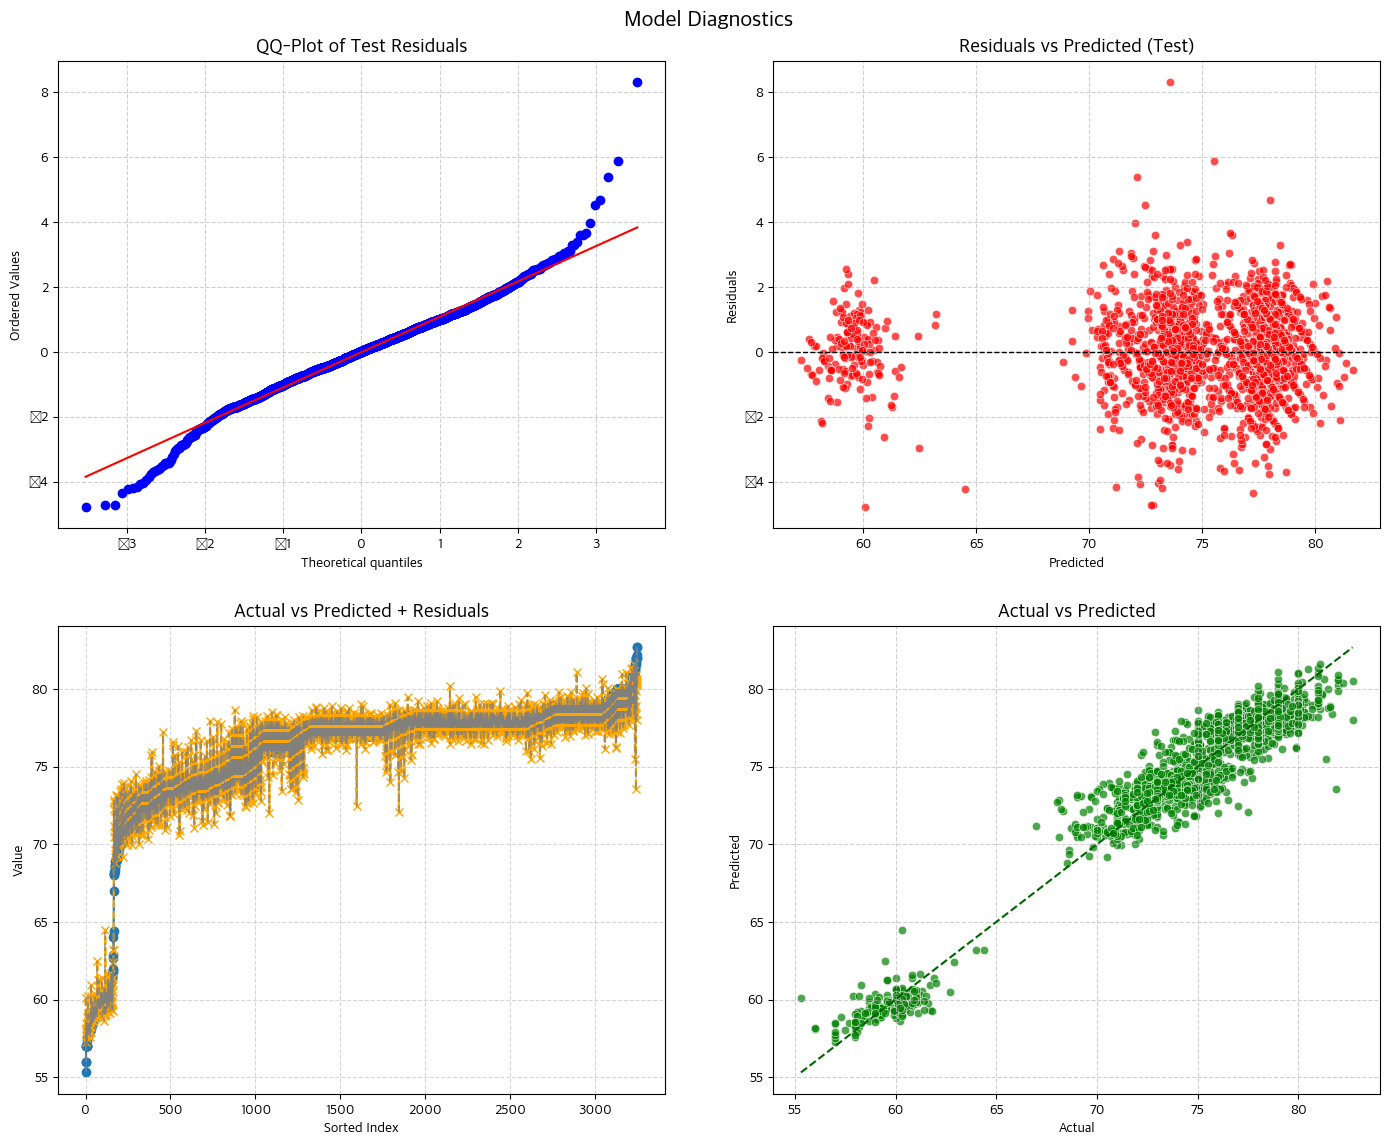

Train Accuracy
Train RMSE : 0.319
Train R2   : 0.995
Train SMAPE : 0.33
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.100
Test R2   : 0.938
Test SMAPE : 1.12


In [11]:
### Modelling 
# CT90 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과')

# Scorch 
sc_model, sc_importance = train_tree(sc_train_dataset, sc_test_dataset, target_col='Scorch_결과')

# Vm 
vm_model, vm_importance = train_tree(vm_train_dataset, vm_test_dataset, target_col='Vm_결과')

# Hard 
hard_model, hard_importance = train_tree(hard_train_dataset, hard_test_dataset, target_col='경도_결과') 

## ***Feature Importance***
---

In [12]:
### Shap Tree 적용 
# CT90 
ct_shap_values, ct_filtered_dataset, ct_feature_importance = shap_tree(dataset, ct_scaler, ct_scaler_cols, ct_model, p_type, target_col=targets[0], cluster=cluster)

# Scorch 
sc_shap_values, sc_filtered_dataset, sc_feature_importance = shap_tree(dataset, sc_scaler, sc_scaler_cols, sc_model, p_type, target_col=targets[1], cluster=cluster)

# Vm 
vm_shap_values, vm_filtered_dataset, vm_feature_importance = shap_tree(dataset, vm_scaler, vm_scaler_cols, vm_model, p_type, target_col=targets[2], cluster=cluster)

# Hard 
hard_shap_values, hard_filtered_dataset, hard_feature_importance = shap_tree(dataset, hard_scaler, hard_scaler_cols, hard_model, p_type, target_col=targets[3], cluster=cluster)

# Voting 
feature_importances = [ct_feature_importance,sc_feature_importance,vm_feature_importance,hard_feature_importance]
cluster_feature_importance = voting_feature_importance(feature_importances) 

# Print 
print('='*100)
print(f'Cluster {cluster} Shap Tree Feature Importance 추출 완료')
print('='*100)

Cluster 1 | Ct 90_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (7534, 20)
Optimal Target 조건 적용된 데이터 수: (413, 20)
✅ 적절한 데이터 수 확보 (1430개, std=3.00%)
모든 조건이 필터링된 데이터 수: (1430, 20)


100%|===================| 1425/1430 [03:40<00:00]        

Cluster 1 | Scorch_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (10313, 20)
Optimal Target 조건 적용된 데이터 수: (977, 20)
✅ 적절한 데이터 수 확보 (2989개, std=3.00%)
모든 조건이 필터링된 데이터 수: (2989, 20)


100%|===================| 2986/2989 [07:08<00:00]        

Cluster 1 | Vm_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (22857, 20)
✅ 적절한 데이터 수 확보 (1305개, std=1.00%)
모든 조건이 필터링된 데이터 수: (1305, 20)


100%|===================| 1299/1305 [01:46<00:00]        

Cluster 1 | 경도_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (17106, 20)
✅ 적절한 데이터 수 확보 (2794개, std=1.00%)
모든 조건이 필터링된 데이터 수: (2794, 20)


100%|===================| 2791/2794 [15:26<00:00]        

Cluster 1 Shap Tree Feature Importance 추출 완료


In [21]:
def voting_feature_importance(feature_importances): 
    ''' 
    각 Target별 Importance DF Voting 후 -> Top 7 Features 추출 

    Returns: Feature Importance 
    ''' 
    # Rank + Vote 컬럼 생성 
    long_frames = []

    for i, df in enumerate(feature_importances):
        # Target 이름: DataFrame.name 사용, 없으면 자동 생성
        target_name = df['Target'].iloc[0] 
        
        # Temp df 생성 
        temp_df = df[['feature', 'mean_abs_shap']].copy()

        # 내림차순 랭크 (값이 클수록 중요)
        temp_df['Rank'] = temp_df['mean_abs_shap'].rank(ascending=False, method='dense')

        # 투표 점수: importance * (1 / Rank)
        temp_df['Vote'] = temp_df['mean_abs_shap'] / temp_df['Rank']
        temp_df['Target'] = target_name

        # Append Temp df 
        long_frames.append(temp_df)
    
    # Concat Long Frames 
    long_df = pd.concat(long_frames, ignore_index=True) 

    # To Pivot 
    pivot_importance = long_df.pivot(
                                    index='Target',
                                    columns='feature',
                                    values='mean_abs_shap'
                                    )

    # Voting 집계 및 결과 DF 구성
    agg = (long_df
           .groupby('feature', as_index=False)
           .agg(
               Voting=('Vote', 'sum'),
               등장빈도=('Target', 'nunique'),
               평균중요도=('mean_abs_shap', 'mean'),
               관련타겟=('Target', lambda x: ', '.join(sorted(pd.unique(x))))
           ))

    # 사용자가 정의한 스키마로 맞추고, Voting으로 정렬하되 출력 컬럼은 틀 유지
    out = (agg
           .sort_values('Voting', ascending=False)
           .rename(columns={
               'feature': 'Features',
               '등장빈도': '등장 빈도',
               'Voting': 'Voting',
               '관련타겟': '관련 타겟'
           })[['Features', '등장 빈도', 'Voting', '관련 타겟']]
           .reset_index(drop=True))

    return out

In [22]:
cluster_feature_importance = voting_feature_importance(feature_importances) 
cluster_feature_importance

,Features,등장 빈도,Voting,관련 타겟
0,step1_Rotor speed,4,34.008340,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
1,필팩터,4,20.154657,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
2,Vm_feature,4,19.633588,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
3,step2_Rotor speed,4,3.227381,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
4,step3_Rotor speed,4,3.168289,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
5,step1_time,4,2.649834,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
6,step3_전력량,4,1.333251,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
7,TA_MIN,4,1.326943,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
8,step2_mix온도,4,0.929271,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
9,step3_mix온도,4,0.732400,"Ct 90_결과, Scorch_결과, Vm_결과, 경도_결과"
